# Sparse Conv Feature

In [1]:
from voxelize import *
import os
from tqdm import tqdm
# data_path = '/home/jiazx_ug/dataset/S4/O/training/velodyne/335422.bin'
# label_path = '/home/jiazx_ug/dataset/S4/O/training/label_2/335422.txt'

data_dir = '/home/jiazx_ug/dataset/S4/O/training/velodyne/'
label_dir = '/home/jiazx_ug/dataset/S4/O/training/label_2/'
ckpt_path = '/home/jiazx_ug/OpenPCDet/output/kitti_models/voxel_rcnn_car/A_S22/ckpt/checkpoint_epoch_160.pth'
idx_list = [str(data.split('.')[0]) for data in os.listdir(data_dir)]
idx_list.sort()

In [2]:
label_dict = {'Car':0, 'Pedestrian':1, 'Rider':2, 'Truck':3, 'Van':4}
vsize_xyz = np.array([0.5, 0.5, 1])       
coors_range_xyz = np.array([-70.4, -40, -3, 70.4, 40, 1])  
num_point_features = 4                                 
max_num_points_per_voxel = 5               
max_num_voxels = 16000
input_channels = 4

grid_size = get_grid_size(coors_range_xyz, vsize_xyz)
backbone = input_backbone(input_channels, grid_size)
backbone = load_model_params(ckpt_path, backbone)
checker = isPointInQuadrangle()


In [3]:
all_features = []
all_labels = []

for idx in tqdm(idx_list):
    data_path = data_dir + idx + '.bin'
    label_path = label_dir + idx + '.txt'
    
    points = read_data(data_path)
    voxels, voxel_indices, num_points = create_voxel(points, vsize_xyz, coors_range_xyz,num_point_features ,max_num_points_per_voxel, max_num_voxels)
    input_feature, input_indices = get_input_feature(voxels, num_points, voxel_indices, backbone)
    indices_3d = indices_to_3d(input_indices, grid_size)

    corners_3Ds, label_obj = read_label(label_path)
    corners_voxelaxis = corners_to_voxelaxis(corners_3Ds, coors_range_xyz, vsize_xyz)
    feature_keys = get_inner_voxel(corners_voxelaxis, checker)
    features, labels = get_inner_voxel_feature(input_feature, indices_3d, feature_keys, grid_size, label_obj)
    all_features += features
    all_labels += labels
    
    #tqdm.write(f"IDX {idx} with {len(features)}, all {len(all_features)}")


100%|██████████| 11938/11938 [12:12<00:00, 16.30it/s]


In [4]:
feature_array = np.array(all_features)
feature_array.shape

(5687309, 16)

# MRMR

In [5]:
import pandas as pd
from mrmr import mrmr_classif
feature_array = pd.DataFrame(feature_array)
feature_label = pd.Series(all_labels)
feature_array.shape, feature_label.shape

((5687309, 16), (5687309,))

In [6]:
selected_features = mrmr_classif(X=feature_array, y=feature_label, K=3)
selected_features

100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


[12, 3, 6]

In [7]:
feature_array.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.918650,0.0,1.058323,0.0,1.152370,0.0,1.315330,0.0,0.404153,0.0,0.773109,1.100838,0.494891,0.000000,0.782414,0.853536
1,0.918650,0.0,1.058323,0.0,1.152370,0.0,1.315330,0.0,0.404153,0.0,0.773109,1.100838,0.494891,0.000000,0.782414,0.853536
2,1.368973,0.0,1.095008,0.0,0.482093,0.0,0.448311,0.0,1.796058,0.0,0.000000,0.000000,0.959406,0.453912,1.358377,0.000000
3,0.918650,0.0,1.058323,0.0,1.152370,0.0,1.315330,0.0,0.404153,0.0,0.773109,1.100838,0.494891,0.000000,0.782414,0.853536
4,0.918650,0.0,1.058323,0.0,1.152370,0.0,1.315330,0.0,0.404153,0.0,0.773109,1.100838,0.494891,0.000000,0.782414,0.853536


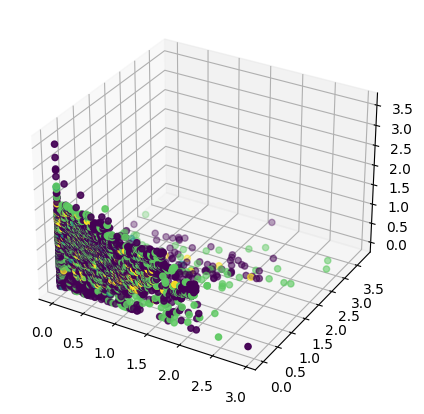

In [8]:
# visualize the selected features in 3d, color by label
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

idx = np.random.choice(len(feature_array), len(feature_array)//1000)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature_array[selected_features[0]].iloc[idx], feature_array[selected_features[1]].iloc[idx], feature_array[selected_features[2]].iloc[idx], c=feature_label.iloc[idx])
plt.show()


# Selection